[*********************100%***********************]  1 of 1 completed


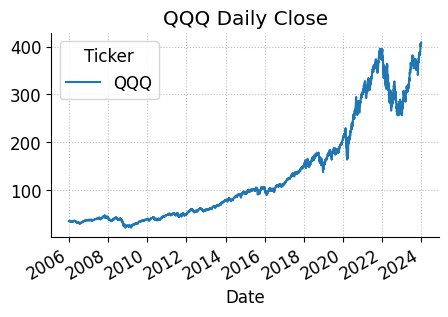

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import yfinance as yf

style.use("default")

params = {
    "axes.labelsize": 12, "font.size": 12, "legend.fontsize": 12,
    "xtick.labelsize": 12, "ytick.labelsize": 12, "text.usetex": False,
    "font.family": "sans-serif", "axes.spines.top": False, "axes.spines.right": False,
    "grid.color": "grey", "axes.grid": True,  "grid.alpha": 0.5, "grid.linestyle": ":",
}

plt.rcParams.update(params)
# use Yahoo Finance to download historical data for QQQ
# over the last 15 years, from 2006-01-01 to 2021-01-01
qqq_daily = yf.download("QQQ", start="2006-01-01", end="2023-12-31")
qqq_daily["Close"].plot(title="QQQ Daily Close", figsize=(5, 3))
plt.show()

In [4]:
# calculate monthly returns of QQQ
qqq_monthly = qqq_daily["Close"].resample("ME").ffill()
qqq_monthly.index = qqq_monthly.index.to_period("M")
qqq_monthly["Return"] = qqq_monthly["QQQ"].pct_change() * 100
qqq_monthly.dropna(inplace=True)

# Step 2: Load the monthly three factors into a dataframe
# CSV columns: , Mkt-RF, SMB, HML, RF
# The first columns represents the date
# The first row contains the column names
ff_factors_monthly = pd.read_csv(
    "F-F_Research_Data_Factors-monthly.CSV", index_col=0
)
ff_factors_monthly.index.names = ["Date"]
ff_factors_monthly.index = pd.to_datetime(ff_factors_monthly.index, format="%Y%m")
ff_factors_monthly.index = ff_factors_monthly.index.to_period("M")
ff_factors_monthly

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.96,-2.56,-2.43,0.22
1926-08,2.64,-1.17,3.82,0.25
1926-09,0.36,-1.40,0.13,0.23
1926-10,-3.24,-0.09,0.70,0.32
1926-11,2.53,-0.10,-0.51,0.31
...,...,...,...,...
2024-08,1.61,-3.55,-1.13,0.48
2024-09,1.74,-0.17,-2.59,0.40
2024-10,-0.97,-1.01,0.89,0.39


In [5]:
# Filter factor dates to match the asset
ff_factors_subset = ff_factors_monthly[
    ff_factors_monthly.index.isin(qqq_monthly.index)
].copy()

# Step 3: Calculate excess returns for the asset
ff_factors_subset["Excess_Return"] = qqq_monthly["Return"] - ff_factors_subset["RF"]
ff_factors_subset

,Mkt-RF,SMB,HML,RF,Excess_Return
Date,,,,,
2006-02,-0.30,-0.38,-0.34,0.34,-2.482812
2006-03,1.46,3.44,0.60,0.37,1.720978
2006-04,0.73,-1.42,2.34,0.36,-0.550835
2006-05,-3.57,-2.96,2.41,0.43,-7.670095
2006-06,-0.35,-0.39,0.85,0.40,-0.461573
...,...,...,...,...,...
2023-08,-2.39,-3.20,-1.08,0.45,-1.933003
2023-09,-5.24,-2.49,1.45,0.43,-5.509872
2023-10,-3.18,-3.88,0.19,0.47,-2.535492


In [6]:
import statsmodels.api as sm

# Prepare the independent variables (add a constant to the model)
X = sm.add_constant(ff_factors_subset[["Mkt-RF", "SMB", "HML"]])
# The dependent variable
y = ff_factors_subset["Excess_Return"]
# Run the regression
model = sm.OLS(y, X).fit()
# Display the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     680.6
Date:                Tue, 11 Mar 2025   Prob (F-statistic):          3.48e-108
Time:                        11:45:54   Log-Likelihood:                -413.35
No. Observations:                 215   AIC:                             834.7
Df Residuals:                     211   BIC:                             848.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2397      0.116      2.067      0.0

# Factor Interpretation
### Constant (const)

* Coefficient: 0.2397
* This represents the average monthly return of QQQ in excess of the risk-free rate that is not explained by the three Fama-French factors. It's statistically significant (p-value: 0.040), suggesting a positive alpha or performance unrelated to these factors.

### Market Excess Return (Mkt-Rf)
* Coefficient: 1.1338
* This indicates that QQQ has a strong positive relationship with market excess returns. A 1% increase in market excess returns is associated with a 1.1338% increase in QQQ returns, on average. The coefficient is highly significant (p-value: 0.000), highlighting a strong dependency on market performance.

### Size Factor (SMB)
* Coefficient: -0.0565
* This suggests a slight negative relationship between QQQ returns and the size premium, but the relationship is not statistically significant (p-value: 0.249). This means that QQQ's monthly returns are not significantly affected by the performance difference between small-cap and large-cap stocks.

### Value Factor (HML)
* Coefficient: -0.4178
* QQQ shows a significant negative relationship with the value factor. A 1% increase in the value premium (value stocks outperforming growth stocks) is associated with a 0.4178% decrease in QQQ returns, on average. The coefficient is highly significant (p-value: 0.000), indicating that QQQ, which primarily consists of large tech (often considered growth) stocks, tends to perform inversely to the value factor.

### Factors and Their Highest and Lowest Explanatory Power:
* Highest Explanatory Power: The factor with the highest or lowest coefficient value that is also statistically significant (low p-value) can be considered the most explanatory for the stock's returns. It's the factor to which the stock's returns are most sensitive.
* Lowest Explanatory Power: Conversely, the factor with the smallest absolute coefficient value (close to 0) or a coefficient that is not statistically significant (high p-value) would have the least explanatory power. If a factor's confidence interval includes zero, it also indicates a lack of strong evidence that the factor meaningfully explains the stock's returns.

/var/folders/rn/0lh1z0156hv113bld20hjf440000gn/T/ipykernel_47322/371177196.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Factor", y="Coefficient", data=ols_data, capsize=0.2, palette="coolwarm")


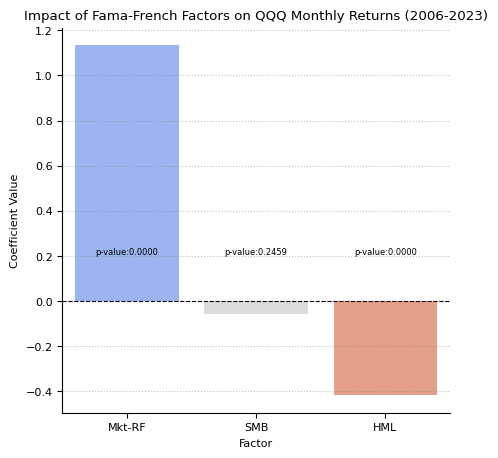

In [8]:
# Step 5.2: Plot the coefficients and their confidence intervals
factors = model.params.index[1:]  # ['Mkt_Rf', 'SMB', 'HML']
coefficients = model.params.values[1:]
confidence_intervals = model.conf_int().diff(axis=1).iloc[1]

# Create a DataFrame
ols_data = pd.DataFrame(
    {
        "Factor": factors,
        "Coefficient": coefficients,
        "Confidence_Lower": confidence_intervals[0],
        "Confidence_Upper": confidence_intervals[1],
    }
)

# Plotting
plt.figure(figsize=(5, 5))
sns.barplot(x="Factor", y="Coefficient", data=ols_data, capsize=0.2, palette="coolwarm")

# Add the p-value for each factor to the plot
for i, row in ols_data.iterrows():
    plt.text(
        i,
        0.2,
        f"p-value:{model.pvalues[row['Factor']]:.4f}",
        ha="center",
        va="bottom",
        fontsize=6,
    )

plt.title("Impact of Fama-French Factors on QQQ Monthly Returns (2006-2023)")
plt.xlabel("Factor"); plt.ylabel("Coefficient Value")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.show()